In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import csv
from scipy.stats import multivariate_normal
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
def pca(x, y, k):
    x = x.reshape(x.shape[0], -1)
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    standadized_x = (x - mean) / std
    covariance_matrix = np.cov(standadized_x, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues = np.real(eigenvalues)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sum_eigenvalues = np.sum(sorted_eigenvalues)/100
    sorted_eigenvalues = sorted_eigenvalues / sum_eigenvalues
    final_eigenvectors = sorted_eigenvectors[:, :k]
    cumulative_explained_variance = []
    for i in range(0, k):
        cumulative_explained_variance.append(np.sum(sorted_eigenvalues[:i]))
    final_features = np.dot(final_eigenvectors.T, standadized_x.T).T
    return cumulative_explained_variance, final_features

In [3]:
csv_file_path = './SMAI-Dataset-customer-dataset/data.csv'
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    data = []
    for row in csv_reader:
        data.append(row)
    data = data[1:]
    data = np.array(data)
    data = data.astype(float)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data = (data - mean) / std
print((data.shape))

(2000, 8)


In [4]:
number_of_pcs = np.arange(0, 8)
cumulative_explained_variances, principle_components = pca(data,[],8)

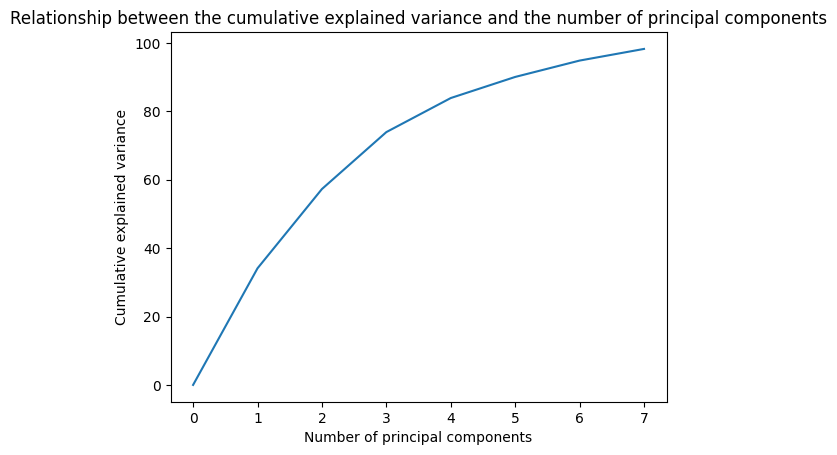

In [5]:
plt.plot(number_of_pcs, cumulative_explained_variances)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

In [6]:
cumulative_explained_variance, principle_components = pca(data,[],8)
print(principle_components[:, :5].shape)

(2000, 5)


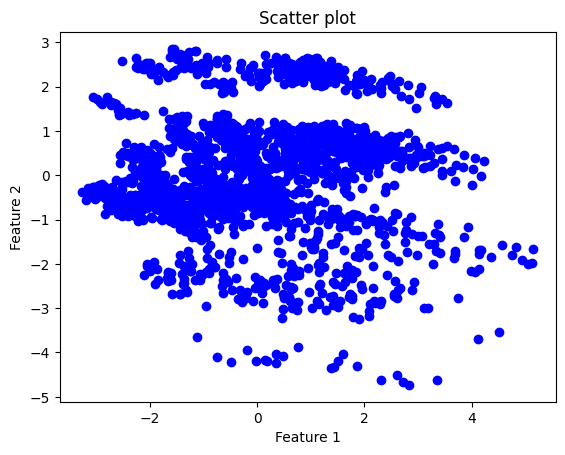

In [7]:
plt.scatter(principle_components[:, 0], principle_components[:, 1], color='blue', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot")
plt.show()

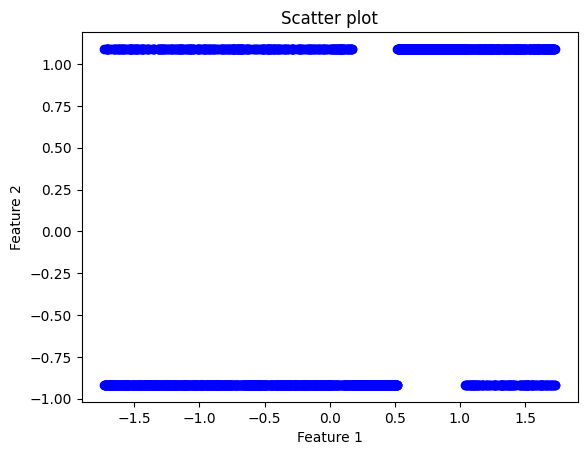

In [8]:
plt.scatter(data[:, 0], data[:, 1], color='blue', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot")
plt.show()

In [9]:
class GMM:
    def fit(self, data, nuber_of_clusters):
        self.data = data
        self.k = nuber_of_clusters
    
    def obtain_parameters(self, max_iterations, cut_off):
        k = self.k
        data = self.data
        np.random.seed(0)
        means = np.random.randn(k, data.shape[1])
        covariances = np.array([np.eye(data.shape[1]) for _ in range(k)])
        weights = np.ones(k) / k
        prev_log_likelihood = -1

        returning = []

        for i in range(0, max_iterations):
            try:
                q = np.zeros((data.shape[0], k))
                for j in range(k):
                    q[:, j] =  weights[j] * multivariate_normal.pdf(data, mean=means[j], cov=covariances[j])
                sum = q.sum(axis=1, keepdims=True)
                q /= sum

                sum = q.sum(axis=0)
                weights = sum / data.shape[0]
                means = (np.dot(q.T, data)) / sum[:, np.newaxis]
                for j in range(k):
                    diff = data - means[j]
                    covariances[j] = np.dot(q[:, j] * diff.T, diff) / sum[j]
                    for m in range(0, data.shape[1]):
                        for n in range(0, data.shape[1]):
                            if m == n:
                                covariances[j][m][n] += 1e-6


                log_likelihood = np.zeros((data.shape[0], k))
                for j in range(k):
                    log_likelihood[:, j] =  weights[j] * multivariate_normal.pdf(data, mean=means[j], cov=covariances[j])
                log_likelihood = log_likelihood.sum(axis=1)
                log_likelihood = np.log(log_likelihood)
                log_likelihood = np.sum(log_likelihood)

                if i > 0 and np.abs(log_likelihood - prev_log_likelihood) < cut_off:
                    break
                prev_log_likelihood = log_likelihood
                returning = q
            except:
                print("returing")
                print(covariances)
                return np.argmax(returning, axis=1)
        labels = np.argmax(q, axis=1)
        return labels, prev_log_likelihood
    
    def find_log_likelihood(self, means, weights, covariances):
        k = self.k
        data = self.data
        log_likelihood = np.zeros((data.shape[0], k))
        for j in range(k):
            log_likelihood[:, j] =  weights[j] * multivariate_normal.pdf(data, mean=means[j], cov=covariances[j])
        log_likelihood = log_likelihood.sum(axis=1)
        log_likelihood = np.log(log_likelihood)
        log_likelihood = np.sum(log_likelihood)

    def find_membership_value(self, means, weights, covariances):
        k = self.k
        data = self.data
        q = np.zeros((data.shape[0], k))
        for j in range(k):
            q[:, j] =  weights[j] * multivariate_normal.pdf(data, mean=means[j], cov=covariances[j])
        sum = q.sum(axis=1, keepdims=True)
        q /= sum
        return q

In [10]:
gmm = GMM()

In [11]:
gmm.fit(principle_components[:, :5], 5)
labels, log_likelihood = gmm.obtain_parameters(200, 1e-9)
print(labels)

[3 4 3 ... 1 4 1]


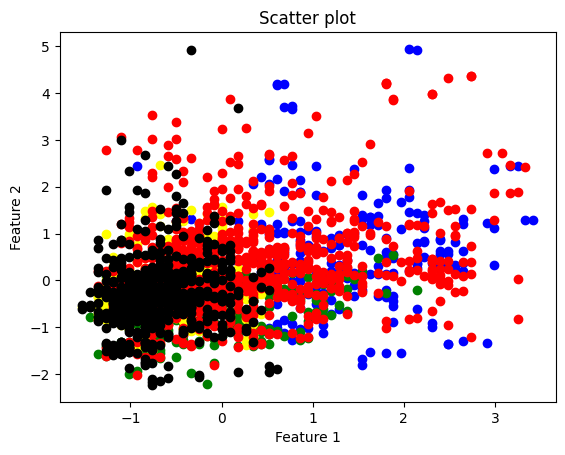

In [12]:
data_blue = data[labels == 0]
data_green = data[labels == 1]
data_yellow = data[labels == 2]
data_red = data[labels == 3]
data_black = data[labels == 4]
plt.scatter(data_blue[:, 3], data_blue[:, 5], c='blue')
plt.scatter(data_green[:, 3], data_green[:, 5], c='green')
plt.scatter(data_yellow[:, 3], data_yellow[:, 5], c='yellow')
plt.scatter(data_red[:, 3], data_red[:, 5], c='red')
plt.scatter(data_black[:, 3], data_black[:, 5], c='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot")
plt.show()

In [13]:
data = load_wine()
print(data.data)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]


In [14]:
mean = np.mean(data.data, axis=0)
std = np.std(data.data, axis=0)
normalized_data = (data.data - mean) / std

In [15]:
cumulative_explained_variances, principle_components = pca(normalized_data,[],2)

In [16]:
aic_arr = []
bic_array = []
number_of_components = []
for components in range(1, 10):
    gmm.fit(principle_components, components)
    labels, log_likelihood = gmm.obtain_parameters(200, 1e-9)
    n_parameters = components * (principle_components.shape[1] * 2 + 1)
    aic = 2 * n_parameters - 2 * log_likelihood
    bic = n_parameters * np.log(principle_components.shape[0]) - 2 * log_likelihood
    number_of_components.append(components)
    aic_arr.append(aic)
    bic_array.append(bic)

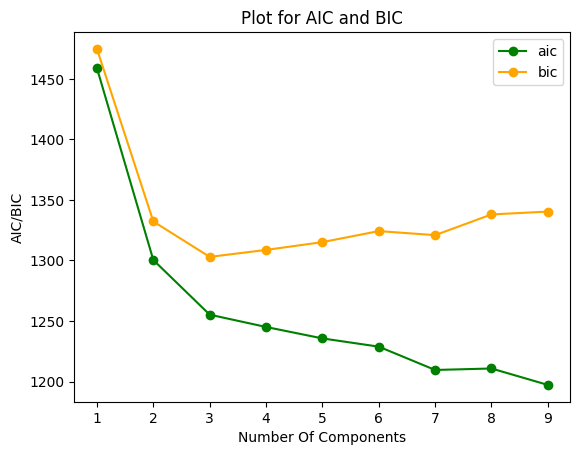

In [17]:
plt.plot(number_of_components, aic_arr, marker='o', linestyle='-', color='g', label='aic')
plt.plot(number_of_components, bic_array, marker='o', linestyle='-', color='orange', label='bic')
plt.xlabel('Number Of Components')
plt.ylabel('AIC/BIC')
plt.title('Plot for AIC and BIC')
plt.legend()
plt.show()

In [18]:
gmm.fit(principle_components, 3)
labels, log_likelihood = gmm.obtain_parameters(200, 1e-9)

In [19]:
silhouette_avg = silhouette_score(principle_components, labels)
print(f"Silhouette Score for GMM: {silhouette_avg}")

Silhouette Score for GMM: 0.558147346129322


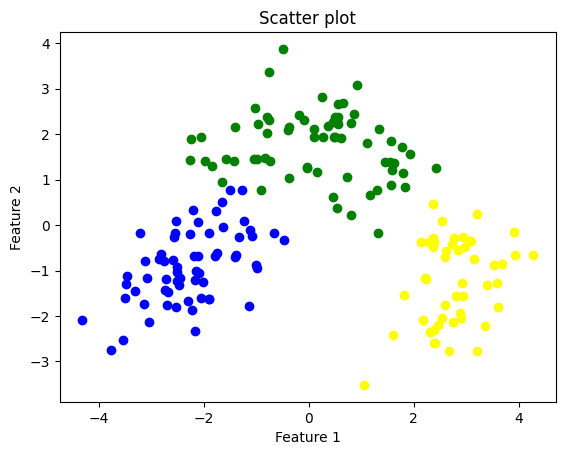

In [20]:
data_blue = principle_components[labels == 0]
data_green = principle_components[labels == 1]
data_yellow = principle_components[labels == 2]
data_red = principle_components[labels == 3]
data_black = principle_components[labels == 4]
plt.scatter(data_blue[:, 0], data_blue[:, 1], c='blue')
plt.scatter(data_green[:, 0], data_green[:, 1], c='green')
plt.scatter(data_yellow[:, 0], data_yellow[:, 1], c='yellow')
plt.scatter(data_red[:, 0], data_red[:, 1], c='red')
plt.scatter(data_black[:, 0], data_black[:, 1], c='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot")
plt.show()

Silhouette Score for K Means: 0.5610505693103246


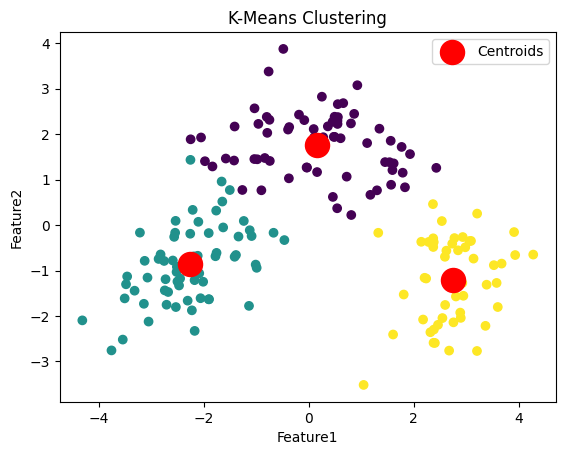

In [21]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(principle_components)
labels = kmeans.labels_
data['Cluster'] = labels
silhouette_avg = silhouette_score(principle_components, labels)
print(f"Silhouette Score for K Means: {silhouette_avg}")
plt.scatter(principle_components[:, 0], principle_components[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('K-Means Clustering')
plt.legend()
plt.show()